In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from textwrap import wrap
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add,Dropout,Embedding,LSTM,Bidirectional,Dense,Input,Concatenate,Reshape,concatenate
from tensorflow.keras.models import Sequential,Model,load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping,ReduceLROnPlateau

In [7]:
img_path  = '/kaggle/input/flickr8k/Images'
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

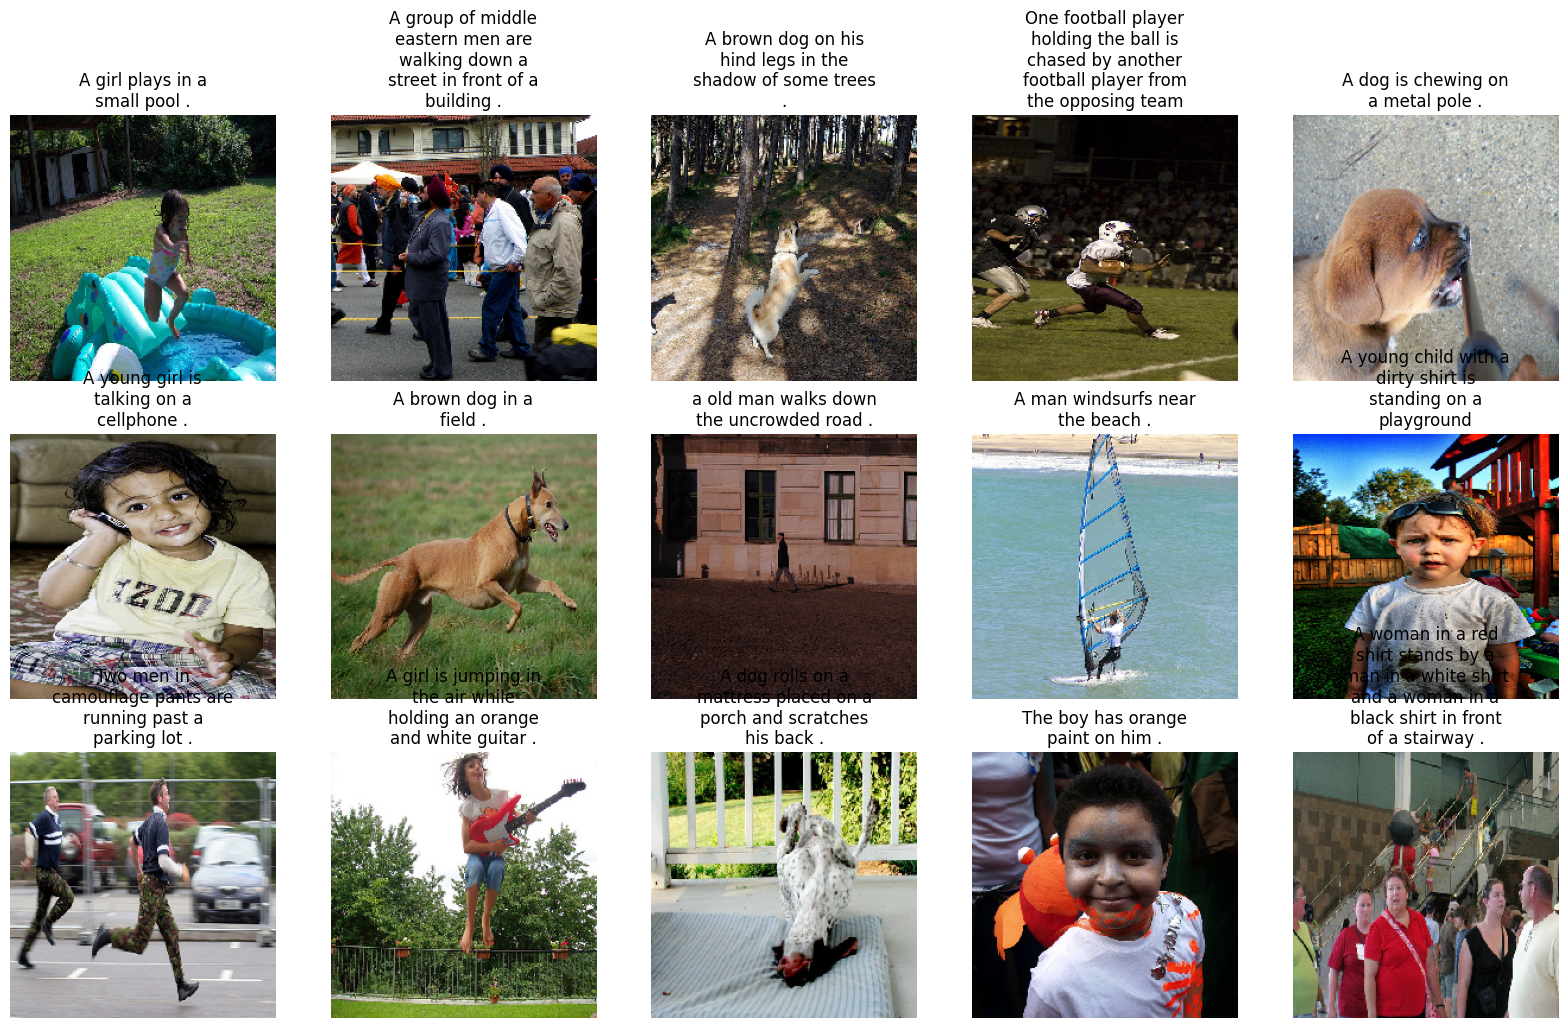

In [4]:
def read_img(path,img_size=224):
    img = load_img(path,target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img


def displayImage(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n=0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        image = read_img(f"/kaggle/input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)))
        plt.axis('off')
        
displayImage(df.sample(15))
    

In [8]:
def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x:x.lower())
    df['caption'] = df['caption'].apply(lambda x:x.replace("[^A-Za-z]",""))
    df['caption'] = df['caption'].apply(lambda x:x.replace("\s+"," "))
    df['caption'] = df['caption'].apply(lambda x:" ".join([word for word in x.split() if len(word)>1]))
    df['caption'] = "<sos> " + df['caption'] + " <end>"
    

    
text_preprocessing(df)
caption = df['caption'].tolist()

In [9]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(caption)
vocab = len(tokenizer.word_index)+1
max_len = max([len(caption.split())for caption in caption])
max_len

34

In [10]:
images  =df['image'].unique().tolist()
len_img = len(images)

split_index = round(0.85*len_img)
train_img = images[:split_index]
test_img = images[split_index:]

train = df[df['image'].isin((train_img))]
test = df[df['image'].isin((test_img))]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [11]:
model = DenseNet201(weights='/kaggle/input/densenet201/tensorflow2/default/1/densenet201_weights_tf_dim_ordering_tf_kernels.h5', include_top=True)


fe = Model(inputs=model.input,outputs=model.layers[-2].output)

img_size=224
features ={}

for image in tqdm(df['image'].unique().tolist()):
    img = load_img(os.path.join(img_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img,verbose=0)
    features[image] = feature

I0000 00:00:1765112746.278915      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1765112759.175479     117 service.cc:148] XLA service 0x7fa3e8002350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765112759.176301     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765112761.333287     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765112774.607470     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [14:27<00:00,  9.32it/s]


In [12]:
fe.save("feature_extractor_model.h5")

In [13]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab
        self.max_length = max_len
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=tokenizer,vocab_size=vocab,max_length=max_len,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=img_path,
                                      tokenizer=tokenizer,vocab_size=vocab,max_length=max_len,features=features)

In [14]:
train_generator[1]

((array([[1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         ...,
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00],
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00],
         [7.6072298e-05, 6.1783084e-04, 1.9857232e-03, ..., 5.4502711e-02,
          1.0848639e+00, 2.5176878e+00]], dtype=float32),
  array([[   0,    0,    0, ...,    0,    0,    2],
         [   0,    0,    0, ...,    0,    2,  184],
         [   0,    0,    0, ...,    2,  184, 1053],
         ...,
         [   0,    0,    0, ...,    4,  773,    3],
         [   0,    0,    0, ...,  773,    3,  258],

In [15]:
input1 =Input(shape=(1920,))
input2 =Input(shape=(max_len,))

img_features = Dense(256,activation='relu')(input1)
img_features_rs = Reshape((1,256),input_shape=(256,))(img_features)

sentence_features = Embedding(vocab,256,mask_zero=False)(input2)

merge = concatenate([img_features_rs,sentence_features],axis=1)
sentence_features=LSTM(256)(merge)

x = Dropout(0.5)(sentence_features)
x = add([x,img_features])

x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)

output=Dense(vocab,activation='softmax')(x)
caption_model = Model(inputs=[input1,input2],outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

model_name = "model.keras" 
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.2,min_lr=1e-8)

history = caption_model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[checkpoint,earlystopping,learning_rate_reduction])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 5.6734
Epoch 1: val_loss improved from inf to 4.28113, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 138ms/step - loss: 5.6723 - val_loss: 4.2811 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 4.3206
Epoch 2: val_loss improved from 4.28113 to 3.94805, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - loss: 4.3205 - val_loss: 3.9480 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.9936
Epoch 3: val_loss improved from 3.94805 to 3.80190, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 72s 133ms/step - loss: 3.9935 - val_loss: 3.8019 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.8087
Epoch 4: val_loss improved from 3.80190 to 3.72349, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 72s 134ms/step - loss: 3.8086 - val_loss: 3.7235 - learning_rate: 0.0010


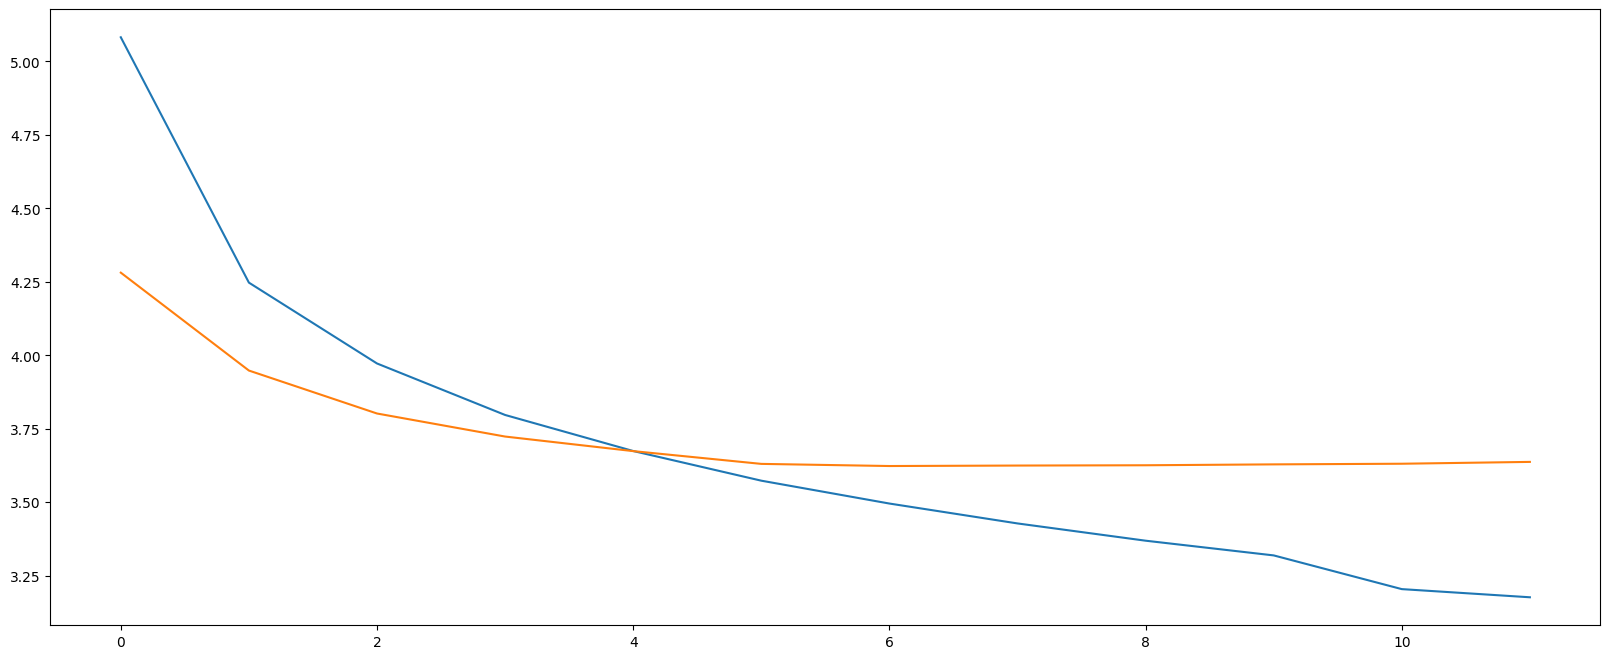

In [16]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [25]:
with open("tokenizer.pkl",'wb') as f:
    pickle.dump(tokenizer,f)

fe.save("fe.keras")

In [27]:
model_path="/kaggle/working/model.keras"
tokenizer_path="/kaggle/working/tokenizer.pkl"
fe_path="/kaggle/working/fe.keras"

In [44]:
def cap_generator(image_path,model_path,tokenizer_path,fe_path,max_len=34,img_size=224):
    caption_model=load_model(model_path)
    fe1 = load_model(fe_path)
    tokenizer = pickle.load(open("tokenizer.pkl",'rb'))

    img = load_img(image_path,target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img,axis=0)

    image_features = fe1.predict(img,verbose=0)

    in_text = "<sos> "
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        y = caption_model.predict([image_features,seq],verbose=0)
        y_index=np.argmax(y)

        word = tokenizer.index_word.get(y_index,None)
        if word is None:
            break
        in_text += " "+word
        if word == 'end':
            break
    caption = in_text.replace('<sos> ','').replace('end','').strip()
    img = load_img(image_path,target_size=(img_size,img_size))

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()

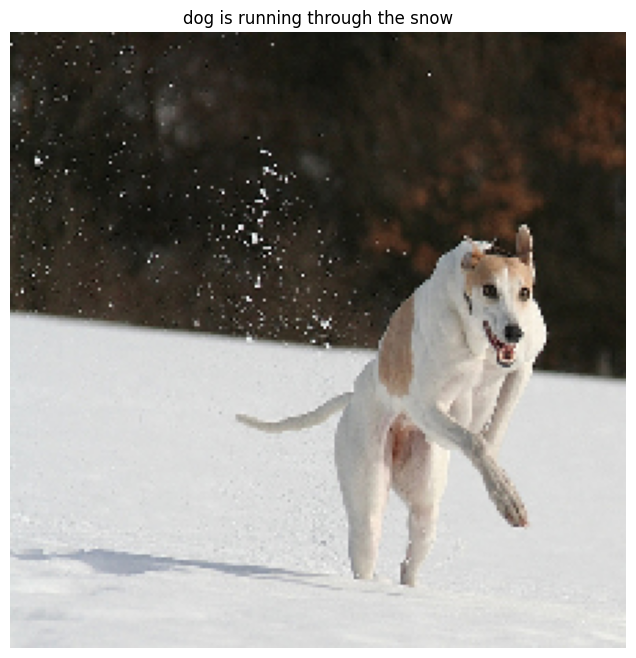

In [46]:
image_path="/kaggle/input/flickr8k/Images/101654506_8eb26cfb60.jpg"
cap_generator(image_path,model_path,tokenizer_path,fe_path)